<a href="https://colab.research.google.com/github/dewizunuvi/Deteksi-Autisme/blob/main/Resnet-50%20Autism%20EPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import keras
import imageio
import numpy as np
from keras import applications
from google.colab import drive
from keras.layers import Flatten
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model 
from keras.losses import categorical_crossentropy
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

In [2]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from PIL import Image

In [3]:
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

#   **Load Data**




In [4]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import imageio

# Mount Google Drive
drive.mount('/content/drive')

# Set path to folder containing GIF files
folder_path_autism = "/content/drive/MyDrive/DataAutisEPI/AUTISM"
folder_path_control = "/content/drive/MyDrive/DataAutisEPI/TC"

# List GIF files from folder 1
files1 = [os.path.join(folder_path_autism, f) for f in os.listdir(folder_path_autism) if f.endswith('.gif')]

# List GIF files from folder 2
files2 = [os.path.join(folder_path_control, f) for f in os.listdir(folder_path_control) if f.endswith('.gif')]

# Load images from the two folders
images1 = [imageio.imread(f) for f in files1]
images2 = [imageio.imread(f) for f in files2]

# Convert images to PIL Image objects
images1 = [Image.fromarray(image) for image in images1]
images2 = [Image.fromarray(image) for image in images2]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-5-8d77202333ff>:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images1 = [imageio.imread(f) for f in files1]
<ipython-input-5-8d77202333ff>:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images2 = [imageio.imread(f) for f in files2]


In [6]:
# Combine the two sets of images
dataf = images1 + images2

# Generate labels for the images
labels = [1] * len(images1) + [0] * len(images2)

In [7]:
# Convert GIF images to JPG format with resize
jpg_images = []
for image in dataf:
    # Resize the image to the desired size
    resized_image = image.resize((64, 64))

    # Generate unique output file name for each image
    output_file = f"output_{len(jpg_images)}.jpg"

    # Save the image in JPG format
    resized_image.save(output_file, "JPEG")

    # Append the output file name to the list of JPG images
    jpg_images.append(output_file)

In [8]:
array_list = []

# Menyimpan gambar-gambar ke dalam array_list
for images in jpg_images:
    image = Image.open(images)
    image = image.convert("RGB")  # Jika gambar bukan dalam format RGB
    image_array = np.array(image)
    array_list.append(image_array)

# Memeriksa ukuran yang sama dalam array_list
ref_shape = array_list[0].shape
for array in array_list:
    if array.shape != ref_shape:
        print("Ukuran tidak sesuai")
        break
else:
    print("Semua elemen memiliki ukuran yang sama")

Semua elemen memiliki ukuran yang sama


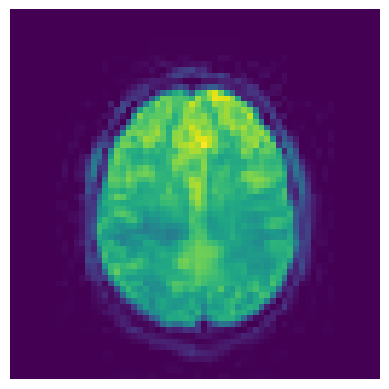

In [9]:
# Load the JPG image
image_path = jpg_images[0]
image = Image.open(image_path)

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()

#Turn to RGB

In [10]:
data_array = np.array(array_list)

In [11]:
data_array.shape

(1068, 64, 64, 3)

# Urus bawah ini dengan convert label ke np array dlu

In [12]:
x_train, x_test, y_train, y_test = train_test_split(data_array, labels, test_size=0.2)
y_train=np.array(y_train)

x_train = x_train.astype('float32')
y_train = keras.utils.to_categorical(y_train)
y_old_test=y_test
y_test = keras.utils.to_categorical(y_test)

In [13]:
x_train.shape

(854, 64, 64, 3)

#Modelling ResNet50


In [14]:
model = applications.ResNet50(weights = "imagenet", include_top=False, input_shape =(64, 64, 3))

for layer in model.layers:
    layer.trainable = True
#Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)
model= Model(inputs = model.input, outputs = predictions)

94765736/94765736 [==============================] - 5s 0us/step


#Train

In [15]:
# Split data into K=5 folds
kfold = KFold(n_splits=7, shuffle=True, random_state=42)

In [16]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with K-fold cross validation
for fold, (train_idx, val_idx) in enumerate(kfold.split(x_train, y_train)):
    print(f'Fold {fold+1} Training ------------')
    x_train_fold = x_train[train_idx]
    y_train_fold = y_train[train_idx]
    x_val_fold = x_train[val_idx]
    y_val_fold = y_train[val_idx]

    history = model.fit(x_train_fold, y_train_fold, batch_size=100, epochs=30, validation_data=(x_val_fold, y_val_fold))

    print(f"Fold {fold+1} Validation Accuracy: {np.mean(history.history['val_accuracy']):.4f}")

Fold 1 Training ------------
Epoch 1/30
8/8 [==============================] - 19s 500ms/step - loss: 1.2746 - accuracy: 0.4850 - val_loss: 1.1017 - val_accuracy: 0.4508
Epoch 2/30
8/8 [==============================] - 1s 107ms/step - loss: 0.6403 - accuracy: 0.6803 - val_loss: 1.0135 - val_accuracy: 0.4836
Epoch 3/30
8/8 [==============================] - 1s 105ms/step - loss: 0.3249 - accuracy: 0.8702 - val_loss: 1.1461 - val_accuracy: 0.5328
Epoch 4/30
8/8 [==============================] - 1s 112ms/step - loss: 0.2317 - accuracy: 0.9303 - val_loss: 1.1028 - val_accuracy: 0.5082
Epoch 5/30
8/8 [==============================] - 1s 112ms/step - loss: 0.1550 - accuracy: 0.9740 - val_loss: 1.0494 - val_accuracy: 0.5328
Epoch 6/30
8/8 [==============================] - 1s 113ms/step - loss: 0.1164 - accuracy: 0.9877 - val_loss: 1.0522 - val_accuracy: 0.5492
Epoch 7/30
8/8 [==============================] - 1s 107ms/step - loss: 0.0918 - accuracy: 0.9959 - val_loss: 1.0458 - val_accurac

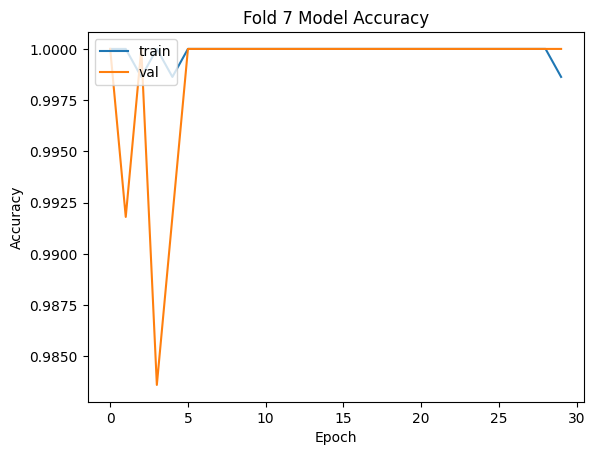

In [17]:
# Plot the training and validation accuracy for each epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(f'Fold {fold+1} Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()